# `ohsome` Tutorial 

This notebook gives a short introduction on how to use `ohsome` for sending requests to the ohsome API and how to convert the responses to `pandas.DataFrame` or `geopandas.GeoDataFrames`. We will perform a [Data Aggregation](https://api.ohsome.org/v0.9/swagger-ui.html?urls.primaryName=Data%20Aggregation) and [Data Extraction](https://api.ohsome.org/v0.9/swagger-ui.html?urls.primaryName=Data%20Extraction) queries.
Please refer to the ohsome API documentation for a full description of all endpoints and query parameters:

* [ohsome API documentation](https://docs.ohsome.org/ohsome-api/stable/index.html), e.g. [endpoints](https://docs.ohsome.org/ohsome-api/stable/endpoints.html), [filters](https://docs.ohsome.org/ohsome-api/stable/filter.html), [boundaries](https://docs.ohsome.org/ohsome-api/stable/boundaries.html), [time](https://docs.ohsome.org/ohsome-api/stable/time.html) and [grouping](https://docs.ohsome.org/ohsome-api/stable/group-by.html)
* [swagger ohsome API](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=dataExtraction)

## 1. Initialize `OhsomeClient`
All queries to the ohsome API are handled through an `OhsomeClient` object. 

In [2]:
from ohsome import OhsomeClient

In [3]:
client = OhsomeClient()

By default the public ohsome API at  is queried. 

In [4]:
client.base_api_url

'https://api.ohsome.org/v1/'

After its initialization you can query metadata of the ohsome API such as start and end timestamp, api version.

In [5]:
client.start_timestamp

'2007-10-08T00:00:00Z'

In [6]:
client.end_timestamp

'2021-03-07T20:00Z'

In [7]:
client.api_version

'1.3.2'

## 2. Data Aggregation

To send a request to one of the endpoints, append the single components of the endpoint URL as method calls to the client. Use code completion (TAB in jupyter) to find valid endpoint components. In the end, call the `post()` method with all necessary parameters to send off the query as a POST request.

### Count OSM objects

__Example:__ Number of features tagged as _highway=*_ within a bounding box in Heidelberg for the years 2010 and 2011. The call is sent to the endpoint [elements/count](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=dataExtraction#/Count/count_1)

In [8]:
bboxes = [8.67066,49.41423,8.68177,49.4204]
time = "2010-01-01/2011-01-01/P1Y"
flter = "highway=* and type:way"

In [9]:
response = client.elements.count.post(bboxes=bboxes, time=time, filter=flter)

Alternatively you can also specify the endpoint in the `OhsomeClient.post()` method:

In [10]:
response = client.post(bboxes=bboxes, time=time, filter=flter, endpoint="elements/count")

Calling `as_dataframe()` converts the response to a `pandas.DataFrame` with the timestamp as index.

In [11]:
response_df = response.as_dataframe()

The result contains the number of highways for each time step:

In [12]:
response_df

,value
timestamp,
2010-01-01 00:00:00+00:00,269.0
2011-01-01 00:00:00+00:00,291.0


You can write the response to a JSON file using

In [13]:
response.to_json("./highways_count.json")

### Count grouped by boundary

If you want to query the number of highways within several bounding boxes you can specify them using a nested list 

In [14]:
bboxes = [[8.67066,49.41423,8.68177,49.4204], [8.68551,49.40086,8.68937,49.40315]]

or a dictionary if you want to pass ids 

In [15]:
bboxes = {"INF": [8.67066,49.41423,8.68177,49.4204], "Weststadt": [8.68551,49.40086,8.68937,49.40315]}

To get separate counts for the bounding boxs, we need to ad `groupByBoundary` to the query.

In [16]:
response = client.elements.count.groupByBoundary.post(bboxes=bboxes, time=time, filter=flter)
response_df = response.as_dataframe()
response_df

value
boundary  timestamp                       
INF       2010-01-01 00:00:00+00:00  269.0
          2011-01-01 00:00:00+00:00  291.0
Weststadt 2010-01-01 00:00:00+00:00   13.0
          2011-01-01 00:00:00+00:00   13.0

The response is converted to a dataframe with a `MultiIndex`, which makes it easier to select subsets of the data based on the boundary and time attributes.

In [17]:
response_df.loc[("INF", slice(None)),:]

value
boundary timestamp                       
INF      2010-01-01 00:00:00+00:00  269.0
         2011-01-01 00:00:00+00:00  291.0

In [18]:
response_df.loc[(slice(None), "2010-01-01"),:]

,,value
boundary,timestamp,
INF,2010-01-01 00:00:00+00:00,269.0
Weststadt,2010-01-01 00:00:00+00:00,13.0


### Count grouped by boundary and OSM tag

Grouping the result by tag, will result in a dataframe with three index levels.

In [19]:
groupByKey = "highway"
flter = "highway=* and type:way"
response = client.elements.count.groupByBoundary.groupByTag.post(bboxes=bboxes, time=time, 
                                                                 filter=flter, groupByKey=groupByKey)
response_df = response.as_dataframe()

In [20]:
response_df.loc[(slice(None), slice(None), "2010-01-01"),:].droplevel(2)

value
boundary  tag                         
INF       highway=cycleway         5.0
          highway=footway        116.0
          highway=living_street    0.0
          highway=path             6.0
          highway=pedestrian       8.0
          highway=primary          8.0
          highway=residential     20.0
          highway=service         77.0
          highway=steps            9.0
          highway=track            3.0
          highway=unclassified    17.0
Weststadt highway=cycleway         0.0
          highway=footway          1.0
          highway=living_street   11.0
          highway=path             0.0
          highway=pedestrian       0.0
          highway=primary          0.0
          highway=residential      1.0
          highway=service          0.0
          highway=steps            0.0
          highway=track            0.0
          highway=unclassified     0.0

## 2. Data Extraction

You can also download OSM features (and optionally their history) at certain timestamps using the [Data Extraction](https://api.ohsome.org/v0.9/swagger-ui.html?urls.primaryName=Data%20Extraction) endpoints.

### Extracting OSM features

Extracting OSM features at a specific point in time is done through the [elements/geometry](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/) endpoint. It is also possible to only retrieve the [centroids](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/Data%20Extraction/centroid_1) or [bounding boxes](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/Data%20Extraction/bbox_1) of the features. 

__Example:__ Extract all building features with their geometry on 2010-01-01 at Heidelberg University. 

In [21]:
bboxes = [8.67066,49.41423,8.68177,49.4204]
time = "2020-01-01"
flter = "building=* and type:way"
properties = "tags" # to retreive OSM tags along with the geometries

In [22]:
response = client.elements.geometry.post(bboxes=bboxes, time=time, filter=flter, properties=properties)

Calling `as_geodataframe()` converts the response to a `geopandas.GeoDataFrame`.

In [23]:
response_df = response.as_geodataframe()

In [24]:
response_df.head()

,,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,building,building:levels,name,office,short_name,...,fuel:diesel,fuel:octane_95,roof:orientation,layer,construction,stairwell,bicycle_parking,capacity,covered,power
@osmId,@snapshotTimestamp,,,,,,,,,,,,,,,,,,,,,
way/116595528,2020-01-01,"POLYGON ((8.67688 49.41799, 8.67749 49.41809, ...",Heidelberg,9,69120,Gundolfstraße,yes,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/139641705,2020-01-01,"POLYGON ((8.67087 49.41635, 8.67096 49.41635, ...",Heidelberg,305,69120,Im Neuenheimer Feld,university,NaN,Institut für Immunologie und Serologie / Unishop,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/141216650,2020-01-01,"POLYGON ((8.67091 49.41682, 8.67106 49.41682, ...",Heidelberg,306,69120,Im Neuenheimer Feld,university,NaN,"Theoretikum, Unterrichtsbereich",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/141216656,2020-01-01,"POLYGON ((8.67066 49.41715, 8.67070 49.41715, ...",Heidelberg,307,69120,Im Neuenheimer Feld,university,NaN,Institut für Anatomie,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/141216661,2020-01-01,"POLYGON ((8.67066 49.41762, 8.67066 49.41762, ...",Heidelberg,308,69120,Im Neuenheimer Feld,university,NaN,Hörsäle Physik,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

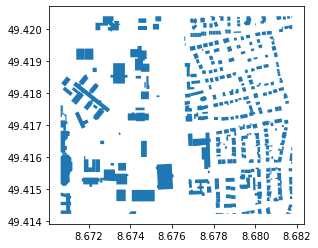

In [25]:
response_df.plot()

You may write the reponse to file using

In [26]:
response.to_json("./buildings_inf.geojson")

### Extracting Full History of OSM features

Using the [elementsFullHistory](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/Full-History%20Data%20Extraction/fullHistory_1) endpoints you can query all versions of the OSM features within a time period. 

__Example:__ Extract all buildings features with their history between 2010 and 2018.

In [27]:
bboxes = "8.67066,49.41423,8.68177,49.4204"
time = "2010-01-01,2018-01-01"
flter = "building=* and type:way"
properties = "tags" # to retreive OSM tags along with the geometries

In [28]:
response = client.elementsFullHistory.geometry.post(bboxes=bboxes, time=time, filter=flter, properties=properties)

Using the method `as_geodataframe()` the response is converted to a `GeoDataFrame` with a multiindex containing OSM ID, validFrom and validTo parameters.

In [29]:
buildings_history = response.as_geodataframe()
buildings_history.head()

geometry  \
@osmId        @validFrom          @validTo                                                                 
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01  POLYGON ((8.67686 49.41804, 8.67747 49.41814, ...   
              2014-10-10 11:24:01 2018-01-01 00:00:00  POLYGON ((8.67686 49.41804, 8.67747 49.41814, ...   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52  POLYGON ((8.67087 49.41635, 8.67096 49.41635, ...   
              2011-12-14 21:03:52 2012-02-24 14:17:17  POLYGON ((8.67087 49.41635, 8.67096 49.41635, ...   
              2012-02-24 14:17:17 2012-08-24 11:10:31  POLYGON ((8.67087 49.41635, 8.67096 49.41635, ...   

                                                      addr:housenumber  \
@osmId        @validFrom          @validTo                               
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01              NaN   
              2014-10-10 11:24:01 2018-01-01 00:00:00                9   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52              305   
              2011-12-14 21:03:52 2012-02-24 14:17:17              305   
              2012-02-24 14:17:17 2012-08-24 11:10:31              305   

                                                      building  \
@osmId        @validFrom          @validTo                       
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01      yes   
              2014-10-10 11:24:01 2018-01-01 00:00:00      yes   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52      yes   
              2011-12-14 21:03:52 2012-02-24 14:17:17      yes   
              2012-02-24 14:17:17 2012-08-24 11:10:31      yes   

                                                      building:material  \
@osmId        @validFrom          @validTo                                
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01               NaN   
              2014-10-10 11:24:01 2018-01-01 00:00:00               NaN   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52               NaN   
              2011-12-14 21:03:52 2012-02-24 14:17:17               NaN   
              2012-02-24 14:17:17 2012-08-24 11:10:31               NaN   

                                                        addr:city  \
@osmId        @validFrom          @validTo                          
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01         NaN   
              2014-10-10 11:24:01 2018-01-01 00:00:00  Heidelberg   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52  heidelberg   
              2011-12-14 21:03:52 2012-02-24 14:17:17  Heidelberg   
              2012-02-24 14:17:17 2012-08-24 11:10:31  Heidelberg   

                                                      addr:postcode  \
@osmId        @validFrom          @validTo                            
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01           NaN   
              2014-10-10 11:24:01 2018-01-01 00:00:00         69120   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52           NaN   
              2011-12-14 21:03:52 2012-02-24 14:17:17           NaN   
              2012-02-24 14:17:17 2012-08-24 11:10:31           NaN   

                                                      addr:province  \
@osmId        @validFrom          @validTo                            
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01           NaN   
              2014-10-10 11:24:01 2018-01-01 00:00:00           NaN   
way/139641705 2011-12-14 15:12:21 2011-12-14 21:03:52           NaN   
              2011-12-14 21:03:52 2012-02-24 14:17:17           NaN   
              2012-02-24 14:17:17 2012-08-24 11:10:31           NaN   

                                                               addr:street  \
@osmId        @validFrom          @validTo                                   
way/116595528 2011-06-06 12:51:43 2014-10-10 11:24:01                  NaN   
              2014-10-10 11:24:01 2018-01-01 00:00:00        Gundolfstraße   
way/139641705 2011-12-14 15:12:21 2011-

Since the timestamp is given in the index, you can slice the data as before. 

**Example:** Select all versions of the OSM object with ID 'way/25205983'.

In [30]:
buildings_history.loc["way/25205983",:]

,,geometry,addr:housenumber,building,building:material,addr:city,addr:postcode,addr:province,addr:street,amenity,name,...,fuel:octane_95,atm,wheelchair:toilet,books,shop,university,INF 230,layer,construction,stairwell
@validFrom,@validTo,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,2011-12-14 21:04:31,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,yes,NaN,NaN,NaN,NaN,Im Neuenheimer Feld,university,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-14 21:04:31,2012-02-24 14:17:07,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,yes,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,university,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-24 14:17:07,2012-07-17 05:25:02,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,yes,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-17 05:25:02,2014-05-10 22:08:51,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,university,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-10 22:08:51,2014-09-07 20:55:18,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,university,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-07 20:55:18,2015-05-03 10:16:40,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-03 10:16:40,2016-07-28 15:44:48,"POLYGON ((8.67320 49.42040, 8.67320 49.42025, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-28 15:44:48,2017-03-30 23:27:51,"POLYGON ((8.67320 49.42040, 8.67320 49.42025, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-30 23:27:51,2018-01-01 00:00:00,"POLYGON ((8.67320 49.42040, 8.67320 49.42025, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Example:** Selecting all versions which have been created in 2015:

In [31]:
selected = buildings_history.loc[(slice(None), 
                                    slice("2015-01-01","2015-12-31"), 
                                    slice(None)),:]

<AxesSubplot:>

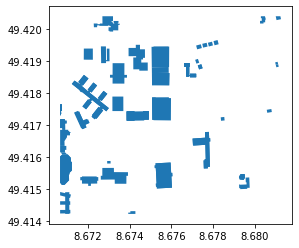

In [32]:
selected.plot()